In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
df = pd.read_csv('311_Service_Requests_K5_ANONYMIZED_GENERALIZED_20251022.csv')
print(df)

            SR_NUMBER                      SR_TYPE SR_SHORT_CODE  \
0       SR25-01948318     Aircraft Noise Complaint           AVN   
1       SR25-01948317   Street Light Out Complaint           SFD   
2       SR25-01948316     Aircraft Noise Complaint           AVN   
3       SR25-01948315    311 INFORMATION ONLY CALL        311IOC   
4       SR25-01948314     Aircraft Noise Complaint           AVN   
...               ...                          ...           ...   
193836  SR25-01702694  Dead Animal Pick-Up Request           SGQ   
193837  SR25-01702693     Aircraft Noise Complaint           AVN   
193838  SR25-01702692   Street Light Out Complaint           SFD   
193839  SR25-01702691   Street Light Out Complaint           SFD   
193840  SR25-01702690    311 INFORMATION ONLY CALL        311IOC   

                         CREATED_DEPARTMENT  \
0                                   Unknown   
1       CDOT - Department of Transportation   
2                                   Unknow


Model Performance After Log Transform:
MAE  (Mean Absolute Error): 8.77 hours
RMSE (Root Mean Squared Error): 36.50 hours
R²   (Explained Variance): 0.821

Top Features Predicting Time to Close:
SR_SHORT_CODE          0.536845
CLOSED_HOUR            0.201810
SR_TYPE                0.065741
CREATED_DAY_OF_WEEK    0.037151
CLOSED_DAY_OF_WEEK     0.036531
CREATED_MONTH          0.024208
CLOSED_MONTH           0.017669
WARD                   0.013691
ORIGIN                 0.012934
COMMUNITY_AREA         0.012933
dtype: float64


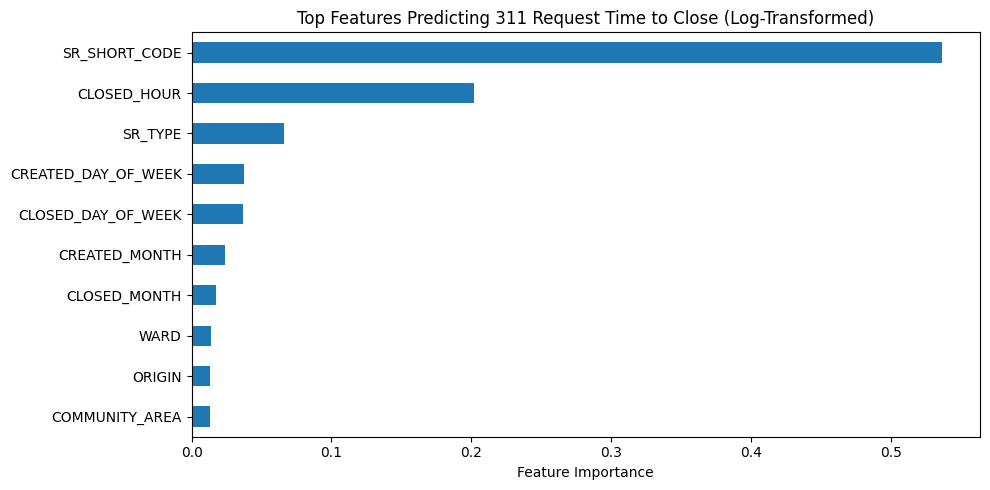

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

for col in ["CREATED_DATE", "CLOSED_DATE", "LAST_MODIFIED_DATE"]:
    df[col] = pd.to_datetime(df[col], errors="coerce")


df["TIME_TO_CLOSE_HOURS"] = (df["CLOSED_DATE"] - df["CREATED_DATE"]).dt.total_seconds() / 3600

# Remove missing or invalid closure times
df = df.dropna(subset=["TIME_TO_CLOSE_HOURS"])
df = df[df["TIME_TO_CLOSE_HOURS"] > 0]

# Log-transform the time to close
df["LOG_TIME_TO_CLOSE"] = np.log1p(df["TIME_TO_CLOSE_HOURS"])


df["CREATED_HOUR"] = df["CREATED_DATE"].dt.hour
df["CREATED_DAY_OF_WEEK"] = df["CREATED_DATE"].dt.dayofweek
df["CREATED_MONTH"] = df["CREATED_DATE"].dt.month

df["CLOSED_HOUR"] = df["CLOSED_DATE"].dt.hour
df["CLOSED_DAY_OF_WEEK"] = df["CLOSED_DATE"].dt.dayofweek
df["CLOSED_MONTH"] = df["CLOSED_DATE"].dt.month


feature_cols = [
    "SR_TYPE",
    "SR_SHORT_CODE",
    "CREATED_DEPARTMENT",
    "OWNER_DEPARTMENT",
    "STATUS",
    "ORIGIN",
    "CITY",
    "STATE",
    "ZIP_CODE",
    "COMMUNITY_AREA",
    "WARD",
    "ELECTRICAL_DISTRICT",
    "POLICE_DISTRICT",
    "CREATED_HOUR",
    "CREATED_DAY_OF_WEEK",
    "CREATED_MONTH",
    "CLOSED_HOUR",
    "CLOSED_DAY_OF_WEEK",
    "CLOSED_MONTH",
]

X = df[feature_cols].copy()
y = df["LOG_TIME_TO_CLOSE"]


for col in X.select_dtypes(include=["object"]).columns:
    X[col] = X[col].fillna("Unknown")
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)


y_pred_log = rf.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# Evaluate model performance
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"\nModel Performance After Log Transform:")
print(f"MAE  (Mean Absolute Error): {mae:.2f} hours")
print(f"RMSE (Root Mean Squared Error): {rmse:.2f} hours")
print(f"R²   (Explained Variance): {r2:.3f}")

# Feature importance
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\nTop Features Predicting Time to Close:")
print(importances.head(10))

plt.figure(figsize=(10, 5))
importances.head(10).plot(kind="barh")
plt.title("Top Features Predicting 311 Request Time to Close (Log-Transformed)")
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

**Analysis of Random Forest Model Results**


From the data, the feature that was the strongest predictor of 311 request time to close is sr_short_code. Sr_short_code is an identifier representing the type of request being made. This is in line with what we expected, as certain types of request (i.e. street light out complaint) are less urgent than others and may take longer time to resolve.

The value of R^2 is 0.828, which is fairly high. 82.8% of the differences in closure times between 311 requests can be explained by the features of our model. This suggests the model successfully captures the main patterns in the data.